In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Credit Scoring Model (Random Forest)**
 

In [1]:
# 1) Imports & setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
import joblib

# Optional: XGBoost import (Kaggle usually has it)
try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception as e:
    xgb_available = False
    print("XGBoost not available:", e)

# Optional: SMOTE for imbalance handling
try:
    from imblearn.over_sampling import SMOTE
    smote_available = True
except Exception as e:
    smote_available = False
    print("imblearn (SMOTE) not available:", e)

# Paths (adjust if your dataset folder name differs)
DATA_DIR = '/kaggle/input/code-alpha-creditscoring/'
TRAIN_PATH = os.path.join(DATA_DIR, '/kaggle/input/code-alpha-creditscoring/cs-training.csv')
TEST_PATH  = os.path.join(DATA_DIR, '/kaggle/input/code-alpha-creditscoring/cs-training.csvv')
SAMPLE_PATH = os.path.join(DATA_DIR, '/kaggle/input/code-alpha-creditscoring/sampleEntry.csv')

# Output
OUTPUT_DIR = '/kaggle/working'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Data dir:", DATA_DIR)


imblearn (SMOTE) not available: No module named 'sklearn.utils._metadata_requests'
Data dir: /kaggle/input/code-alpha-creditscoring/


In [3]:
# 2) Load data
train = pd.read_csv('/kaggle/input/code-alpha-creditscoring/cs-training.csv')
test  = pd.read_csv('/kaggle/input/code-alpha-creditscoring/cs-test.csv')
sample = pd.read_csv('/kaggle/input/code-alpha-creditscoring/sampleEntry.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()


Train shape: (150000, 12)
Test shape: (101503, 12)


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
# 4) Preprocessing function (clean, impute, scale, feature-engineer)
def preprocess_df(df, fit_imputer=None, fit_scaler=None, is_train=True):
    df = df.copy()
    # If the dataset contains an unnamed index column (common in some Kaggle csv exports), drop it
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
    # Keep ID if present
    id_col = None
    for c in ['Id', 'ID', 'id', 'MemberID']:
        if c in df.columns:
            id_col = c
            break

    # If training set: separate target
    target = None
    if is_train and 'SeriousDlqin2yrs' in df.columns:
        target = df['SeriousDlqin2yrs']
        df = df.drop('SeriousDlqin2yrs', axis=1)

    # Example basic feature engineering:
    # - Cap extreme values if needed (simple approach)
    if 'RevolvingUtilizationOfUnsecuredLines' in df.columns:
        df['RevolvingUtilizationOfUnsecuredLines'] = df['RevolvingUtilizationOfUnsecuredLines'].clip(0, 1e6)

    # Impute numeric columns
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Create simple imputer if not provided
    if fit_imputer is None:
        imputer = SimpleImputer(strategy='median')
        imputer.fit(df[num_cols])
    else:
        imputer = fit_imputer
    df[num_cols] = imputer.transform(df[num_cols])

    # Scaling
    if fit_scaler is None:
        scaler = StandardScaler()
        scaler.fit(df[num_cols])
    else:
        scaler = fit_scaler
    df[num_cols] = scaler.transform(df[num_cols])

    # Reattach ID if present
    if id_col:
        ids = df[id_col].values
    else:
        ids = None

    out = {
        'X': df,
        'y': target,
        'imputer': imputer,
        'scaler': scaler,
        'ids': ids
    }
    return out

# Create preprocessing fitted on training data
prep_train = preprocess_df(train, fit_imputer=None, fit_scaler=None, is_train=True)
X_all = prep_train['X']
y_all = prep_train['y']
imputer = prep_train['imputer']
scaler = prep_train['scaler']

print("Preprocessed X shape:", X_all.shape)


Preprocessed X shape: (150000, 10)


In [6]:
# 5) Train/validation split (stratified)
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)
print(X_train.shape, X_val.shape, y_train.value_counts(normalize=True).to_dict())


(120000, 10) (30000, 10) {0: 0.9331583333333333, 1: 0.06684166666666666}


In [7]:
# 6) Optional: handle class imbalance with SMOTE
use_smote = True if smote_available else False
if use_smote:
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    print("After SMOTE, class distribution:", pd.Series(y_train_res).value_counts(normalize=True).to_dict())
else:
    X_train_res, y_train_res = X_train, y_train
    print("SMOTE not used; using original train distribution.")


SMOTE not used; using original train distribution.


In [8]:
# 7) Define models to train
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
}
if xgb_available:
    models['XGBoost'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train each model and evaluate on validation set
results = {}
for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_val)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_val)[:,1]
    else:
        # Some models may not have predict_proba; use decision_function if available
        try:
            y_proba = model.decision_function(X_val)
        except:
            y_proba = np.zeros_like(y_val, dtype=float)

    prec, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='binary', zero_division=0)
    roc = roc_auc_score(y_val, y_proba) if len(np.unique(y_val))>1 else np.nan
    cm = confusion_matrix(y_val, y_pred)
    results[name] = {
        'model': model,
        'precision': prec,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc,
        'confusion_matrix': cm,
        'y_proba': y_proba,
        'y_pred': y_pred
    }
    print(f"{name} -> Precision: {prec:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc:.4f}")
    print("Confusion matrix:\n", cm)




Training LogisticRegression ...
LogisticRegression -> Precision: 0.1818, Recall: 0.6703, F1: 0.2860, ROC-AUC: 0.8021
Confusion matrix:
 [[21945  6050]
 [  661  1344]]

Training RandomForest ...
RandomForest -> Precision: 0.5634, Recall: 0.1551, F1: 0.2433, ROC-AUC: 0.8435
Confusion matrix:
 [[27754   241]
 [ 1694   311]]

Training XGBoost ...
XGBoost -> Precision: 0.5666, Recall: 0.2080, F1: 0.3043, ROC-AUC: 0.8596
Confusion matrix:
 [[27676   319]
 [ 1588   417]]


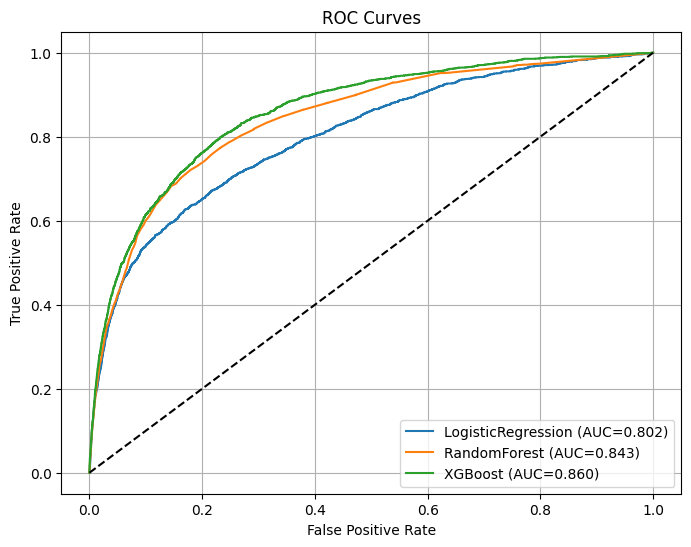

In [9]:
# 8) Plot ROC curves for models that have probabilities
plt.figure(figsize=(8,6))
for name, res in results.items():
    if 'y_proba' in res:
        try:
            fpr, tpr, _ = roc_curve(y_val, res['y_proba'])
            plt.plot(fpr, tpr, label=f"{name} (AUC={res['roc_auc']:.3f})")
        except Exception as e:
            pass
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# 9) Choose best model (by ROC-AUC or F1) - here we use ROC-AUC when available
best_name = max(results.keys(), key=lambda n: (results[n]['roc_auc'] if not np.isnan(results[n]['roc_auc']) else -1))
best_model = results[best_name]['model']
print("Best model:", best_name, "ROC-AUC:", results[best_name]['roc_auc'], "F1:", results[best_name]['f1'])


Best model: XGBoost ROC-AUC: 0.8596055939807563 F1: 0.30426851514045966


In [11]:
# Save best model
model_path = os.path.join(OUTPUT_DIR, f"best_model_{best_name}.joblib")
joblib.dump({'model': best_model, 'imputer': imputer, 'scaler': scaler}, model_path)
print("Saved model to:", model_path)


Saved model to: /kaggle/working/best_model_XGBoost.joblib


In [14]:
# ---- Fix warning and regenerate submission ----
import pandas as pd
import numpy as np
import os

TEST_PATH = '/kaggle/input/code-alpha-creditscoring/cs-test.csv'
SAMPLE_PATH = '/kaggle/input/code-alpha-creditscoring/sampleEntry.csv'
OUTPUT_DIR = '/kaggle/working'
raw_test = pd.read_csv(TEST_PATH)
sample = pd.read_csv(SAMPLE_PATH)

# training numeric columns used by imputer/scaler (from your earlier print)
train_num_cols = ['RevolvingUtilizationOfUnsecuredLines','age',
                  'NumberOfTime30-59DaysPastDueNotWorse','DebtRatio',
                  'MonthlyIncome','NumberOfOpenCreditLinesAndLoans',
                  'NumberOfTimes90DaysLate','NumberRealEstateLoansOrLines',
                  'NumberOfTime60-89DaysPastDueNotWorse','NumberOfDependents']

# prepare test: add missing cols and keep only training numeric cols
test_df = raw_test.copy()
for col in train_num_cols:
    if col not in test_df.columns:
        test_df[col] = np.nan

test_prepared = test_df[train_num_cols].copy()   # ensure exact order

# impute -> gives numpy array
X_test_imputed = imputer.transform(test_prepared)

# convert to DataFrame with same column names BEFORE scaling to avoid warning
X_test_imputed_df = pd.DataFrame(X_test_imputed, columns=train_num_cols, index=test_prepared.index)

# scale using scaler fitted on DataFrame (no warning now)
X_test_scaled = scaler.transform(X_test_imputed_df)
X_test_final = pd.DataFrame(X_test_scaled, columns=train_num_cols, index=test_prepared.index)

# ID extraction (fallback to index+1 if no ID column)
id_col = None
for cand in ['Id','ID','id','IdNumber','Loan_ID','CustomerID','member_id']:
    if cand in raw_test.columns:
        id_col = cand
        break
if id_col is None:
    ids = np.arange(1, len(X_test_final)+1)
else:
    ids = raw_test[id_col].values

# predict probabilities and save submission
if hasattr(best_model, "predict_proba"):
    preds_proba = best_model.predict_proba(X_test_final)[:,1]
else:
    preds_proba = best_model.predict(X_test_final)

submission = pd.DataFrame({'Id': ids, 'Probability': preds_proba})

# match sampleEntry column if needed
if 'SeriousDlqin2yrs' in sample.columns:
    submission = submission.rename(columns={'Probability':'SeriousDlqin2yrs'})
    submission = submission[['Id','SeriousDlqin2yrs']]

submission_path = os.path.join(OUTPUT_DIR, 'submission.csv')
submission.to_csv(submission_path, index=False)
print("Submission saved to:", submission_path)
print(submission.head())


Submission saved to: /kaggle/working/submission.csv
   Id  Probability
0   1     0.041291
1   2     0.048058
2   3     0.014251
3   4     0.058232
4   5     0.095861
